# Visual Stimuli Analysis (Looming)

This notebook demonstrates how to analyze fly responses to visual stimuli,
particularly looming stimuli that simulate approaching objects.

## Overview

Visual stimuli experiments present expanding discs (looming) to flies during free flight.
Key stimulus parameters include:
- **l/v ratio**: Size-to-velocity ratio (ms) - controls apparent approach speed
- **expansion_duration_ms**: How long the expansion lasts
- **initial/final_size_deg**: Start and end size of the stimulus
- **stimulus_offset_deg**: Angular offset from fly's heading

In [29]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import braidz_analysis as ba

print(f"braidz_analysis version: {ba.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
braidz_analysis version: 0.3.0


## 1. Load Data

Load a .braidz file containing visual stimulus data. The `stim` attribute
will contain the stimulus events with their parameters.

In [30]:
# Load your .braidz file
files = [
    "/mnt/data/experiments/20260115_171408.braidz",
    "/mnt/data/experiments/20260117_125304.braidz",
]
data = ba.read_braidz(files)

# For this example, we'll show the expected structure
# Uncomment and modify the path above for your data

# Example: Check what's in the data
print(f"Trajectories: {len(data.trajectories)} rows")
print(f"Stimuli: {len(data.stim)} events")

2026-01-19 13:56:52,762 [ERROR] Invalid ZIP file: /mnt/data/experiments/20260115_171408.braidz


2026-01-19 13:57:19,285 [WARNING] Skipped 1 file(s) due to errors


Trajectories: 7124361 rows
Stimuli: 272 events


## 2. Explore Stimulus Metadata

The visual_stimuli.csv contains rich metadata about each stimulus presentation.

In [31]:
# Expected columns in visual_stimuli.csv:
stim_columns = [
    "timestamp",  # When stimulus was triggered
    "obj_id",  # Fly ID
    "frame",  # Frame number
    "braid_timestamp",  # Braid system timestamp
    "trigger_timestamp",  # Trigger timestamp
    "stimulus_type",  # Type of stimulus (e.g., 'looming')
    "fly_heading_rad",  # Fly heading at stimulus onset (radians)
    "fly_heading_deg",  # Fly heading at stimulus onset (degrees)
    "stimulus_offset_deg",  # Angular offset from fly heading
    "stimulus_absolute_angle_deg",  # Absolute position of stimulus
    "pixel_x",
    "pixel_y",  # Stimulus position on screen
    "initial_size_deg",  # Starting size of looming disc
    "final_size_deg",  # Final size of looming disc
    "expansion_duration_ms",  # Duration of expansion
    "hold_time_ms",  # Time held at final size
    "expansion_type",  # Type of expansion (linear, exponential)
    "lv_ratio_ms",  # l/v ratio in ms (key parameter!)
    "circle_color",  # Color of the stimulus
]

print("Stimulus metadata columns:")
for col in stim_columns:
    print(f"  - {col}")

Stimulus metadata columns:
  - timestamp
  - obj_id
  - frame
  - braid_timestamp
  - trigger_timestamp
  - stimulus_type
  - fly_heading_rad
  - fly_heading_deg
  - stimulus_offset_deg
  - stimulus_absolute_angle_deg
  - pixel_x
  - pixel_y
  - initial_size_deg
  - final_size_deg
  - expansion_duration_ms
  - hold_time_ms
  - expansion_type
  - lv_ratio_ms
  - circle_color


In [32]:
# Explore stimulus parameters in your data
stim = data.stim

print("Stimulus parameter ranges:")
print(f"  l/v ratios: {stim['lv_ratio_ms'].unique()}")
print(f"  Expansion durations: {stim['expansion_duration_ms'].unique()}")
print(
    f"  Stimulus offsets: {stim['stimulus_offset_deg'].min():.0f} to {stim['stimulus_offset_deg'].max():.0f} deg"
)
print(f"  Stimulus types: {stim['stimulus_type'].unique()}")

Stimulus parameter ranges:
  l/v ratios: [25.]
  Expansion durations: [300]
  Stimulus offsets: -90 to 90 deg
  Stimulus types: ['looming']


## 3. Configure Analysis

Visual stimuli typically require a longer response window than optogenetic stimuli,
since the behavioral response may be delayed relative to stimulus onset.

In [67]:
# Use the pre-configured STIM_CONFIG or create a custom one
from braidz_analysis.config import STIM_CONFIG, Config

# # Or create a custom config for your specific experiment
custom_config = Config(
    response_delay=0,  # Ignore first 200ms (stimulus expanding)
    response_window=60,  # Look up to 600ms after onset
    pre_frames=50,  # 500ms before stimulus
    post_frames=100,  # 1500ms after stimulus
    saccade_threshold=300,  # deg/s threshold for turn detection
    min_trajectory_frames=300,  # Must accommodate pre+post frames
    min_saccade_spacing=20,  # Minimum spacing between saccades in frames
)
# custom_config = STIM_CONFIG  # Using default for this example

print("\ncustom_config settings:")
for key, value in custom_config.__dict__.items():
    print(f"  {key}: {value}")


custom_config settings:
  fps: 100.0
  pre_frames: 50
  post_frames: 100
  response_delay: 0
  response_window: 60
  saccade_threshold: 300
  min_saccade_spacing: 20
  heading_window: 10
  min_trajectory_frames: 300
  z_bounds: (0.05, 0.3)
  max_radius: 0.23
  min_position_range: 0.05
  smoothing_window: 21
  smoothing_polyorder: 3
  flight_high_threshold: 0.05
  flight_low_threshold: 0.01
  flight_min_frames: 20


## 4. Run Analysis

Use `analyze_event_responses` with the stimulus data. All stimulus metadata
will be preserved in the results for filtering and grouping.

In [34]:
# Run the analysis
results = ba.analyze_event_responses(data.trajectories, data.stim, config=custom_config)

print(results)
print(f"Overall response rate: {results.response_rate:.1%}")

  0%|          | 0/272 [00:00<?, ?it/s]

100%|██████████| 272/272 [00:07<00:00, 34.06it/s]

EventResults(152 events, 148 responses)
Overall response rate: 97.4%


In [35]:
# Check available metadata columns
print("Metadata columns preserved:")
print(results.metadata.columns.tolist())

Metadata columns preserved:
['timestamp', 'braid_timestamp', 'trigger_timestamp', 'stimulus_type', 'fly_heading_rad', 'fly_heading_deg', 'stimulus_offset_deg', 'stimulus_absolute_angle_deg', 'pixel_x', 'pixel_y', 'initial_size_deg', 'final_size_deg', 'expansion_duration_ms', 'hold_time_ms', 'expansion_type', 'lv_ratio_ms', 'circle_color']


## 5. Filter by Stimulus Parameters

The `filter()` method works with both metrics and metadata columns.

In [36]:
# Filter by l/v ratio
# lv_10 = results.filter(lv_ratio_ms=10)
# lv_40 = results.filter(lv_ratio_ms=40)
#
# print(f"l/v = 10ms: {len(lv_10)} trials, {lv_10.response_rate:.1%} response rate")
# print(f"l/v = 40ms: {len(lv_40)} trials, {lv_40.response_rate:.1%} response rate")

In [37]:
# Filter by stimulus position (frontal vs lateral)
frontal = results.filter(mask=np.abs(results.metadata["stimulus_offset_deg"]) < 45)
lateral = results.filter(mask=np.abs(results.metadata["stimulus_offset_deg"]) >= 45)

print(f"Frontal stimuli: {frontal.response_rate:.1%} response rate")
print(f"Lateral stimuli: {lateral.response_rate:.1%} response rate")

Frontal stimuli: 98.0% response rate
Lateral stimuli: 97.1% response rate


In [38]:
# Get responsive vs non-responsive trials
responsive = results.responsive
non_responsive = results.non_responsive

print(f"Responsive: {len(responsive)} trials")
print(f"Non-responsive: {len(non_responsive)} trials")

Responsive: 148 trials
Non-responsive: 4 trials


## 6. Compare Response Rates Across Conditions

Analyze how response rates vary with stimulus parameters.

In [39]:
# Compare response rates by l/v ratio
# lv_ratios = results.metadata['lv_ratio_ms'].unique()
#
# print("Response rate by l/v ratio:")
# for lv in sorted(lv_ratios):
#     subset = results.filter(lv_ratio_ms=lv)
#     print(f"  l/v = {lv:3.0f} ms: {subset.response_rate:5.1%} ({len(subset)} trials)")

In [40]:
# Use compute_response_statistics for automatic grouping
stats = ba.compute_response_statistics(results)
print(stats)

  stimulus_type  stimulus_offset_deg  pixel_y  initial_size_deg  \
0       looming                  -90      540               5.0   
1       looming                    0      540               5.0   
2       looming                   90      540               5.0   

   final_size_deg  expansion_duration_ms  hold_time_ms expansion_type  \
0            45.0                    300           200    exponential   
1            45.0                    300           200    exponential   
2            45.0                    300           200    exponential   

   lv_ratio_ms circle_color  n_events  n_responses  response_rate  \
0         25.0    (0, 0, 0)        46           44       0.956522   
1         25.0    (0, 0, 0)        50           49       0.980000   
2         25.0    (0, 0, 0)        56           55       0.982143   

   mean_heading_change  mean_reaction_time  
0             1.440183           22.977273  
1             2.060701           21.612245  
2             1.500643    

In [41]:
# Plot response rate by l/v ratio
# fig, ax = plt.subplots(figsize=(8, 5))
#
# lv_stats = []
# for lv in sorted(results.metadata['lv_ratio_ms'].unique()):
#     subset = results.filter(lv_ratio_ms=lv)
#     lv_stats.append({
#         'lv_ratio': lv,
#         'response_rate': subset.response_rate,
#         'n_trials': len(subset)
#     })
#
# lv_df = pd.DataFrame(lv_stats)
# ax.bar(lv_df['lv_ratio'].astype(str), lv_df['response_rate'])
# ax.set_xlabel('l/v ratio (ms)')
# ax.set_ylabel('Response rate')
# ax.set_title('Response Rate by Looming Speed')
# ax.set_ylim(0, 1)
#
# # Add trial counts
# for i, row in lv_df.iterrows():
#     ax.annotate(f'n={row["n_trials"]}',
#                 xy=(i, row['response_rate']),
#                 ha='center', va='bottom')
#
# plt.tight_layout()
# plt.show()

## 7. Plot Traces

Visualize angular velocity traces aligned to stimulus onset.

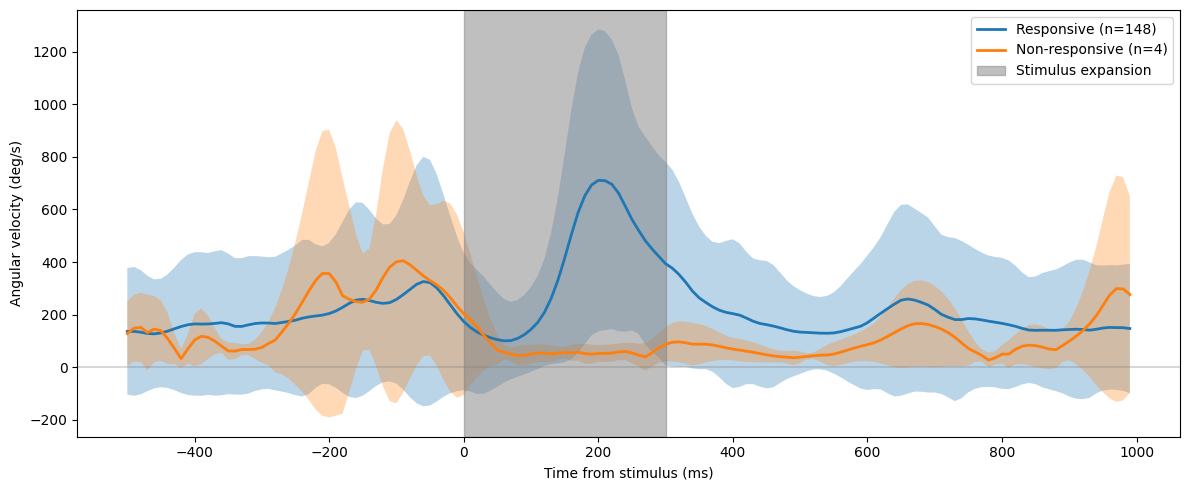

In [66]:
# Plot mean angular velocity traces
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Time axis (centered on stimulus onset)
t = np.arange(-custom_config.pre_frames, custom_config.post_frames) / custom_config.fps * 1000

# Responsive trials
responsive_traces_abs = np.abs(responsive.traces["angular_velocity"])
if len(responsive) > 0:
    omega = np.degrees(responsive_traces_abs)  # Convert to deg/s
    mean_omega = np.mean(omega, axis=0)
    sem_omega = np.std(omega, axis=0)
    ax.fill_between(t, mean_omega - sem_omega, mean_omega + sem_omega, alpha=0.3)
    ax.plot(t, mean_omega, linewidth=2, label=f"Responsive (n={len(responsive)})")

# Non-responsive trials
non_responsive_traces_abs = np.abs(non_responsive.traces["angular_velocity"])
if len(non_responsive) > 0:
    omega = np.degrees(non_responsive_traces_abs)
    mean_omega = np.mean(omega, axis=0)
    sem_omega = np.std(omega, axis=0)

    ax.fill_between(t, mean_omega - sem_omega, mean_omega + sem_omega, alpha=0.3)
    ax.plot(t, mean_omega, linewidth=2, label=f"Non-responsive (n={len(non_responsive)})")

# ax.axvline(0, color="r", linestyle="--", label="Stimulus onset")
ax.axvspan(0, 30 * 1000 / custom_config.fps, color="gray", alpha=0.5, label="Stimulus expansion")
ax.axhline(0, color="gray", linestyle="-", alpha=0.3)
ax.set_xlabel("Time from stimulus (ms)")
ax.set_ylabel("Angular velocity (deg/s)")

ax.legend()


plt.tight_layout()
plt.show()

len(subset) for offset -90: 44
len(subset) for offset 0: 49
len(subset) for offset 90: 55


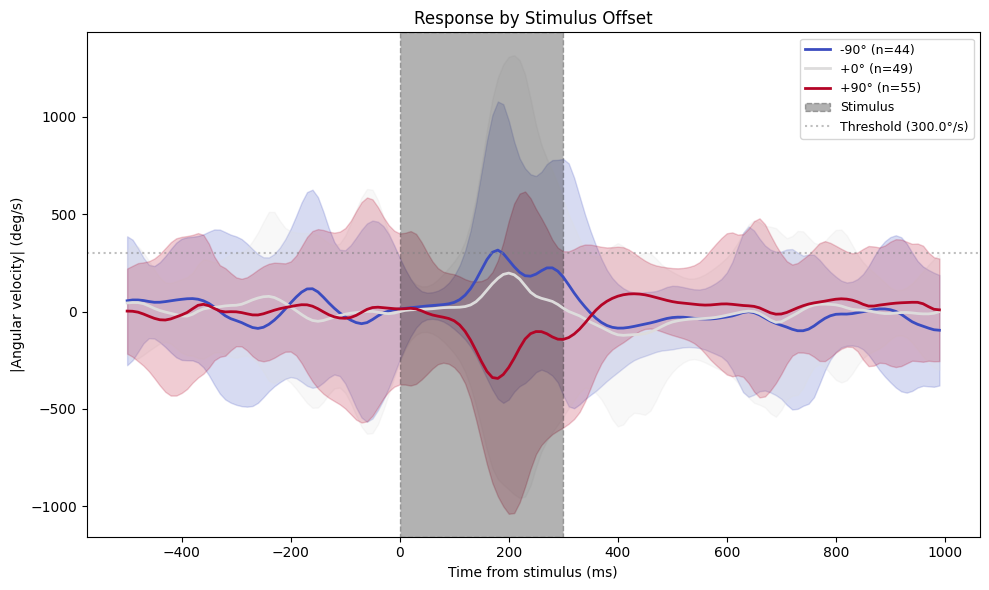

In [65]:
# Plot mean and std traces grouped by stimulus_offset_deg
fig, ax = plt.subplots(figsize=(10, 6))

# Time axis (centered on stimulus onset)
t = np.arange(-custom_config.pre_frames, custom_config.post_frames) / custom_config.fps * 1000

# Get unique stimulus offsets
offsets = sorted(results.metadata["stimulus_offset_deg"].unique())
colors = plt.cm.coolwarm(np.linspace(0, 1, len(offsets)))

for offset, color in zip(offsets, colors):
    mask = (results.metrics["responded"] == True) & (
        results.metadata["stimulus_offset_deg"] == offset
    )
    subset = results.filter(mask=mask)

    print(f"len(subset) for offset {offset}: {len(subset)}")
    if len(subset) > 0:
        # Use absolute angular velocity for magnitude comparison
        omega = np.degrees(subset.traces["angular_velocity"])
        mean_omega = np.mean(omega, axis=0)
        std_omega = np.std(omega, axis=0)

        ax.fill_between(t, mean_omega - std_omega, mean_omega + std_omega, alpha=0.2, color=color)
        ax.plot(t, mean_omega, color=color, linewidth=2, label=f"{offset:+.0f}° (n={len(subset)})")

ax.axvspan(0, 300, color="k", linestyle="--", alpha=0.3, label="Stimulus")
ax.axhline(
    STIM_CONFIG.saccade_threshold,
    color="gray",
    linestyle=":",
    alpha=0.5,
    label=f"Threshold ({STIM_CONFIG.saccade_threshold}°/s)",
)
ax.set_xlabel("Time from stimulus (ms)")
ax.set_ylabel("|Angular velocity| (deg/s)")
ax.set_title("Response by Stimulus Offset")
ax.legend(loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()

In [44]:
# Compare traces by l/v ratio
# fig, ax = plt.subplots(figsize=(10, 6))
#
# colors = plt.cm.viridis(np.linspace(0, 0.8, len(lv_ratios)))
#
# for lv, color in zip(sorted(lv_ratios), colors):
#     subset = results.filter(lv_ratio_ms=lv)
#     if len(subset) > 0:
#         omega = np.degrees(subset.traces['angular_velocity'])
#         mean_omega = np.mean(np.abs(omega), axis=0)  # Absolute value for comparison
#         ax.plot(t, mean_omega, color=color, linewidth=2,
#                 label=f'l/v={lv}ms (n={len(subset)})')
#
# ax.axvline(0, color='r', linestyle='--', alpha=0.5)
# ax.set_xlabel('Time from stimulus (ms)')
# ax.set_ylabel('|Angular velocity| (deg/s)')
# ax.set_title('Response magnitude by looming speed')
# ax.legend()
#
# plt.tight_layout()
# plt.show()

## 8. Analyze Response Metrics

Compare heading changes and reaction times across conditions.

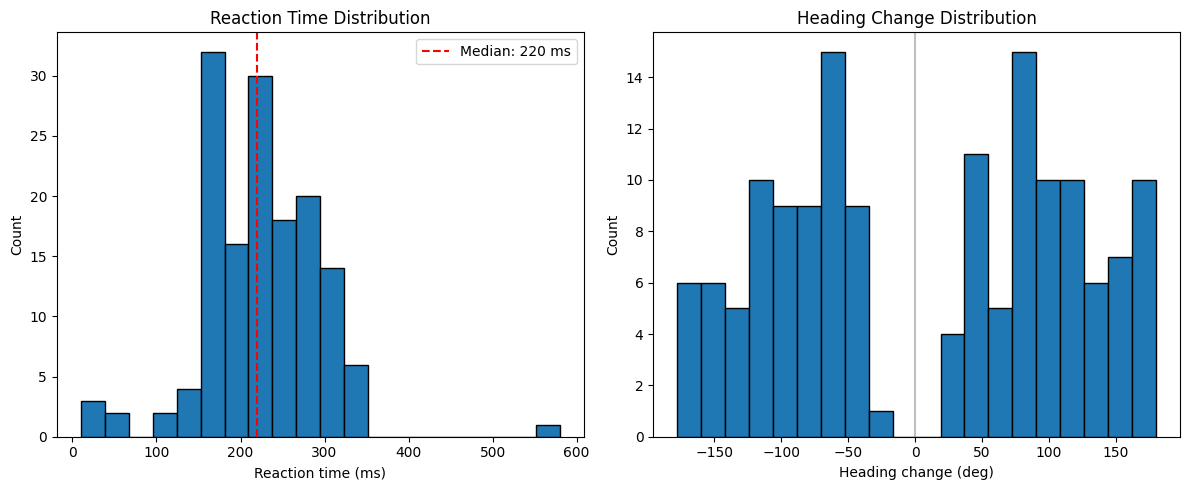

In [53]:
# Reaction time distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Reaction time histogram
ax = axes[0]
rt = responsive.metrics["reaction_time"] / STIM_CONFIG.fps * 1000  # Convert to ms
ax.hist(rt.dropna(), bins=20, edgecolor="black")
ax.axvline(rt.median(), color="r", linestyle="--", label=f"Median: {rt.median():.0f} ms")
ax.set_xlabel("Reaction time (ms)")
ax.set_ylabel("Count")
ax.set_title("Reaction Time Distribution")
ax.legend()

# Heading change distribution
ax = axes[1]
hc = np.degrees(responsive.metrics["heading_change"])  # Convert to degrees
ax.hist(hc.dropna(), bins=20, edgecolor="black")
ax.axvline(0, color="gray", linestyle="-", alpha=0.5)
ax.set_xlabel("Heading change (deg)")
ax.set_ylabel("Count")
ax.set_title("Heading Change Distribution")

plt.tight_layout()
plt.show()

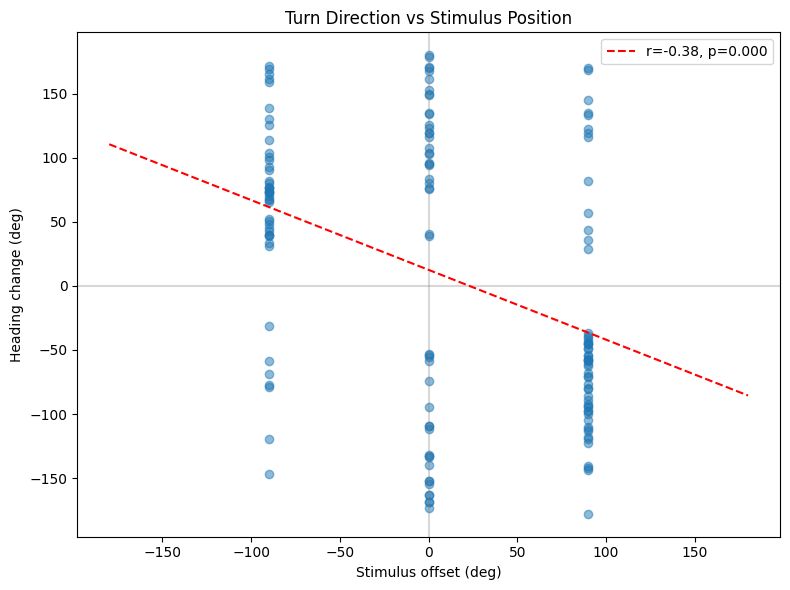

In [60]:
# Heading change vs stimulus offset (do flies turn away from the stimulus?)
fig, ax = plt.subplots(figsize=(8, 6))

# Combine metrics and metadata for plotting
plot_df = pd.concat(
    [responsive.metrics[["heading_change"]], responsive.metadata[["stimulus_offset_deg"]]], axis=1
)

plot_df["heading_change_deg"] = np.degrees(plot_df["heading_change"])

ax.scatter(plot_df["stimulus_offset_deg"], plot_df["heading_change_deg"], alpha=0.5)
ax.axhline(0, color="gray", linestyle="-", alpha=0.3)
ax.axvline(0, color="gray", linestyle="-", alpha=0.3)

# Add regression line
from scipy import stats

slope, intercept, r, p, se = stats.linregress(
    plot_df["stimulus_offset_deg"].dropna(), plot_df["heading_change_deg"].dropna()
)
x_line = np.array([-180, 180])
ax.plot(x_line, slope * x_line + intercept, "r--", label=f"r={r:.2f}, p={p:.3f}")

ax.set_xlabel("Stimulus offset (deg)")
ax.set_ylabel("Heading change (deg)")
ax.set_title("Turn Direction vs Stimulus Position")
ax.legend()

plt.tight_layout()
plt.show()

## 8b. Directional Bias Analysis

Test whether flies turn away from the looming stimulus. For lateral stimuli (-90° or +90°), 
we expect a directional bias in the turn direction. For frontal stimuli (0°), we expect 
no systematic bias.

In [47]:
# Classify turn direction for each trial based on peak_velocity sign
# Positive peak_velocity = left/CCW turn, Negative = right/CW turn

# Combine metrics and metadata
analysis_df = pd.concat([results.metrics, results.metadata], axis=1)


# Classify turn direction
def classify_turn(row):
    if not row["responded"]:
        return "No response"
    elif row["peak_velocity"] > 0:
        return "Left turn"  # CCW / positive angular velocity
    else:
        return "Right turn"  # CW / negative angular velocity


analysis_df["turn_direction"] = analysis_df.apply(classify_turn, axis=1)

# Count by stimulus offset and turn direction
offsets = sorted(analysis_df["stimulus_offset_deg"].unique())
turn_counts = (
    analysis_df.groupby(["stimulus_offset_deg", "turn_direction"]).size().unstack(fill_value=0)
)

# Ensure all columns exist
for col in ["Left turn", "Right turn", "No response"]:
    if col not in turn_counts.columns:
        turn_counts[col] = 0

turn_counts = turn_counts[["Left turn", "Right turn", "No response"]]
print("Turn direction counts by stimulus offset:")
print(turn_counts)
print()

# Calculate percentages
turn_pct = turn_counts.div(turn_counts.sum(axis=1), axis=0) * 100
print("Turn direction percentages:")
print(turn_pct.round(1))

Turn direction counts by stimulus offset:
turn_direction       Left turn  Right turn  No response
stimulus_offset_deg                                    
-90                         36           8            2
 0                          29          20            1
 90                         12          43            1

Turn direction percentages:
turn_direction       Left turn  Right turn  No response
stimulus_offset_deg                                    
-90                       78.3        17.4          4.3
 0                        58.0        40.0          2.0
 90                       21.4        76.8          1.8


2026-01-19 13:57:28,568 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-19 13:57:28,569 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


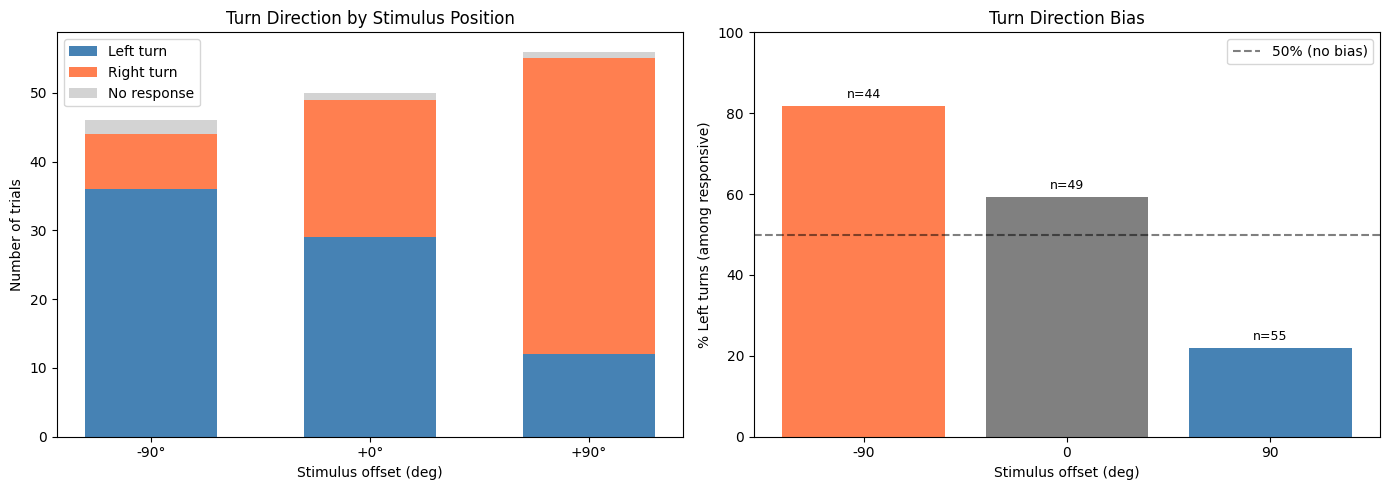

In [48]:
# Stacked bar chart of turn direction by stimulus offset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Stacked bar chart (counts)
ax = axes[0]
x = np.arange(len(offsets))
width = 0.6

bottom = np.zeros(len(offsets))
colors = {"Left turn": "steelblue", "Right turn": "coral", "No response": "lightgray"}

for direction in ["Left turn", "Right turn", "No response"]:
    values = turn_counts[direction].values
    ax.bar(x, values, width, bottom=bottom, label=direction, color=colors[direction])
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels([f"{o:+.0f}°" for o in offsets])
ax.set_xlabel("Stimulus offset (deg)")
ax.set_ylabel("Number of trials")
ax.set_title("Turn Direction by Stimulus Position")
ax.legend()

# Right plot: Percentage of responsive trials that turned left vs right
ax = axes[1]

# Calculate left turn bias among responsive trials only
responsive_df = analysis_df[analysis_df["responded"]]
bias_data = []

for offset in offsets:
    subset = responsive_df[responsive_df["stimulus_offset_deg"] == offset]
    n_total = len(subset)
    if n_total > 0:
        n_left = (subset["turn_direction"] == "Left turn").sum()
        n_right = (subset["turn_direction"] == "Right turn").sum()
        pct_left = n_left / n_total * 100
        bias_data.append(
            {"offset": offset, "pct_left": pct_left, "pct_right": 100 - pct_left, "n": n_total}
        )

bias_df = pd.DataFrame(bias_data)

# Bar chart showing % left turns (with 50% line for reference)
bars = ax.bar(
    bias_df["offset"].astype(str),
    bias_df["pct_left"],
    color=["coral" if o < 0 else "steelblue" if o > 0 else "gray" for o in bias_df["offset"]],
)
ax.axhline(50, color="black", linestyle="--", alpha=0.5, label="50% (no bias)")
ax.set_xlabel("Stimulus offset (deg)")
ax.set_ylabel("% Left turns (among responsive)")
ax.set_title("Turn Direction Bias")
ax.set_ylim(0, 100)
ax.legend()

# Add n values
for i, row in bias_df.iterrows():
    ax.annotate(f"n={row['n']:.0f}", xy=(i, row["pct_left"] + 2), ha="center", fontsize=9)

plt.tight_layout()
plt.show()

In [49]:
# Statistical test: Is the turn direction significantly biased?
# Use binomial test against 50% (no bias) null hypothesis
from scipy.stats import binomtest

print("Binomial test for directional bias (H0: 50% left turns):")
print("-" * 60)

for offset in offsets:
    subset = responsive_df[responsive_df["stimulus_offset_deg"] == offset]
    n_total = len(subset)
    if n_total > 0:
        n_left = (subset["turn_direction"] == "Left turn").sum()

        # Two-sided binomial test
        result = binomtest(n_left, n_total, p=0.5, alternative="two-sided")

        pct_left = n_left / n_total * 100
        sig = (
            "***"
            if result.pvalue < 0.001
            else "**"
            if result.pvalue < 0.01
            else "*"
            if result.pvalue < 0.05
            else ""
        )

        print(
            f"Offset {offset:+4.0f}°: {n_left:2d}/{n_total:2d} left turns ({pct_left:5.1f}%), p={result.pvalue:.4f} {sig}"
        )

print("-" * 60)
print("* p<0.05, ** p<0.01, *** p<0.001")

Binomial test for directional bias (H0: 50% left turns):
------------------------------------------------------------
Offset  -90°: 36/44 left turns ( 81.8%), p=0.0000 ***
Offset   +0°: 29/49 left turns ( 59.2%), p=0.2529 
Offset  +90°: 12/55 left turns ( 21.8%), p=0.0000 ***
------------------------------------------------------------
* p<0.05, ** p<0.01, *** p<0.001


## 9. Compare Responsive vs Non-Responsive Trials

Since v0.3, metrics are computed for all trials (not just responsive ones),
allowing direct comparison.

/tmp/ipykernel_699585/3311878599.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Responsive', 'Non-responsive'])


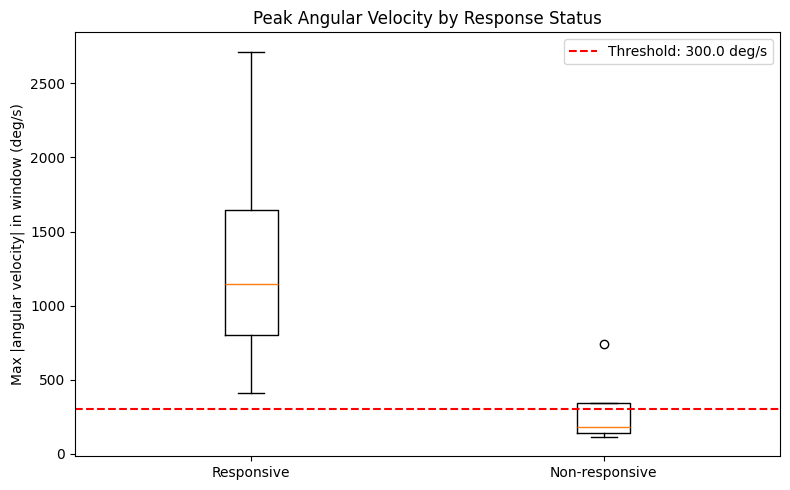

In [50]:
# Compare max velocity in window between responsive and non-responsive
fig, ax = plt.subplots(figsize=(8, 5))

resp_max_vel = np.degrees(responsive.metrics["max_velocity_in_window"])
non_resp_max_vel = np.degrees(non_responsive.metrics["max_velocity_in_window"])

data_to_plot = [resp_max_vel.dropna(), non_resp_max_vel.dropna()]
bp = ax.boxplot(data_to_plot, labels=["Responsive", "Non-responsive"])

ax.axhline(
    STIM_CONFIG.saccade_threshold,
    color="r",
    linestyle="--",
    label=f"Threshold: {STIM_CONFIG.saccade_threshold} deg/s",
)
ax.set_ylabel("Max |angular velocity| in window (deg/s)")
ax.set_title("Peak Angular Velocity by Response Status")
ax.legend()

plt.tight_layout()
plt.show()

## 10. Export Results

Save analysis results for further processing or publication.

In [51]:
# Combine metrics and metadata into a single DataFrame
# full_results = pd.concat([results.metrics, results.metadata], axis=1)
#
# # Convert units for readability
# full_results['heading_change_deg'] = np.degrees(full_results['heading_change'])
# full_results['peak_velocity_deg_s'] = np.degrees(full_results['peak_velocity'])
# full_results['max_velocity_deg_s'] = np.degrees(full_results['max_velocity_in_window'])
# full_results['reaction_time_ms'] = full_results['reaction_time'] / STIM_CONFIG.fps * 1000
#
# # Save to CSV
# # full_results.to_csv('visual_stim_results.csv', index=False)
#
# print("Columns in results:")
# print(full_results.columns.tolist())

## Summary

This notebook demonstrated:

1. **Loading data** with `read_braidz()` - automatically extracts visual_stimuli.csv
2. **Exploring metadata** - all stimulus parameters are preserved
3. **Configuring analysis** - use `STIM_CONFIG` or custom `Config`
4. **Running analysis** - `analyze_event_responses()` handles everything
5. **Filtering results** - by any metric or metadata column
6. **Comparing conditions** - response rates by l/v ratio, position, etc.
7. **Plotting traces** - aligned to stimulus onset
8. **Analyzing metrics** - reaction times, heading changes
9. **Responsive vs non-responsive** - metrics available for all trials

Key stimulus parameters to consider:
- `lv_ratio_ms`: Lower values = faster apparent approach = stronger response
- `stimulus_offset_deg`: Position relative to fly's heading
- `expansion_duration_ms`: Total stimulus duration
- `initial_size_deg` / `final_size_deg`: Size change during expansion